In [1]:
!ls

bin   include		 lib	pyvenv.cfg	       share
code  kaggle-leaf.ipynb  lib64	result3.csv	       test.csv
etc   kaggle-leaf.py	 py	sample_submission.csv  train.csv


In [2]:
import pandas as pd
import numpy as np
import keras

### Image Preprocessing
Loading the images converting them to array and rotating the images and appending them to the same array so as to bring uniformity in the data, i.e. trying to eliminate the problem of different orientations etc.

1.0


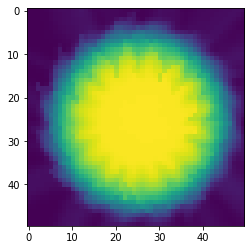

In [3]:
# load images to array

from keras.preprocessing import image
from matplotlib import pyplot as plt
path = "code/images/"
images_arr = []


for i in range(1584):
    img_path = path + str(i+1) + '.jpg'
    
    img = image.load_img(img_path, color_mode='grayscale', target_size=(50,50))
    img_arr = image.img_to_array(img)
    tmp = np.zeros(img_arr.shape)
    tmp += img_arr
    theta = 22.5
    while theta < 360:
        img_arr = image.apply_affine_transform(img_arr, theta=theta)
        tmp += img_arr
        theta += 22.5
    tmp = tmp.astype('float32')
    tmp /= (360/22.5)
    images_arr.append(tmp/255)
    
plt.imshow(image.array_to_img(images_arr[8]))
print(images_arr[8].max())

### Numbering the species name
Reading the csv file using pandas framework and assigning unique ids to the names of the species.
The dataset consists of 64 x 3 features , along with the species name, id (corresponding to the image) and index..

In [4]:
data = pd.read_csv('./train.csv')
print(data.head())
idx = 0
name2id = {}
for sp in data.species:
    if sp not in name2id:
        name2id[sp] = idx
        idx += 1

print(len(name2id))

   id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883  

## Preparing the dataset
Since I am new to the pandas framework, I still don't know how to automate certaing things, so making a whole new separate arrays by iterating over the pandas frame. Of course the process is redundant but aim is to make a neural net.


real_data array consists of the features of the dataset

real_label array consists of the label of the species

real_id consists of the id of the image

Now everything is combined to form one single array of x_train and y_train for training purposes

x_train_img consists of image training data (3-d array of images)

x_train consists of 64x3 features read from the csv file

y_train consists of correct output for the image

we are segregating every 5th image for validation puposes....

which I guess is too much since we are taking out a large chunk of the data

Also converting the y_train and y_test to one hot encoded form for softmax_loss calculation purposes

In [5]:
head = []
# head += ['id', 'species']
head += ['margin'+str(i+1) for i in range(64)]
head += ['shape'+str(i+1) for i in range(64)]
head += ['texture'+str(i+1) for i in range(64)]


real_data = [[] for i in range(990)]
real_label = []
real_id = []
for i in data.id:
    real_id.append(i)
for h in head:
    for i , val in enumerate(data[h]):
        real_data[i].append(val)

for label in data.species:
    real_label.append(name2id[label])

assert(len(real_data) == len(real_label))

#split into train and test data
x_train, y_train, x_test, y_test = [], [], [], []
x_train_img, x_test_img = [], []

for i in range(len(real_data)):
    if i % 5 == 0:
        x_test_img.append(images_arr[ real_id[i] - 1 ])
        x_test.append(real_data[i])
        y_test.append(real_label[i])
        continue
    x_train.append(real_data[i])
    x_train_img.append(images_arr[ real_id[i] - 1 ])
    y_train.append(real_label[i])

x_train = np.array(x_train)
x_train_img = np.array(x_train_img)
x_test = np.array(x_test)
x_test_img = np.array(x_test_img)
y_test = np.array(y_test)
y_train = np.array(y_train)

from keras.utils import to_categorical

y_train = to_categorical(y_train).astype('float32')
y_test = to_categorical(y_test).astype('float32')

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(792, 192)
(198, 192)
(198, 99)
(792, 99)


## Defining the Neural net....
The neural net architecture consists of two sets of layers,

first the set of convolution layers and maxpooling layers which are in the end flattened so as to combine them with the 64x3 features layer..

It is concatenated with the input features layer and then connected further to dense layers , on which Batch normalisation is used, <strong>tried using batch normalisation on conv layers but seems like due to some default settings it doesn't work properly on that hence removed it.</strong>

using basic model in the neural net , without any feature engineering or anything gets a 92% acc but with conv layer gets a 98% accuracy.


In [7]:
input_dim = len(x_train[0])
print(input_dim)



from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

inp_img = Input(shape=(50,50,1), name='input_img')
c1 = Conv2D(16, kernel_size=3, activation='relu')(inp_img) # 48 x 48
# c1 = BatchNormalization()(c1)
p1 = MaxPooling2D(pool_size=(2,1))(c1) # 24 x 48
p1 = MaxPooling2D(pool_size=(1,2))(p1) # 24 x 24
c2 = Conv2D(32, kernel_size=3, activation='relu')(p1) # 22 x 22
# c2 = BatchNormalization()(c2)
p2 = MaxPooling2D(pool_size=(2,1))(c2) # 11 x 22
p2 = MaxPooling2D(pool_size=(1,2))(p2) # 11 x 11
c3 = Conv2D(32, kernel_size=3, activation='relu')(p2) # 9 x 9
# c3 = BatchNormalization()(c3)
f1 = Flatten()(c3) # 64 x 9 x 9 x 16

inp_feat = Input(shape=(input_dim, ), name='input_feat')
x = concatenate([inp_feat, f1])
# d = Dense(5000, activation='relu')(x)
d = Dense(1500, activation='relu')(x)
d = BatchNormalization()(d)
d = Dense(1000, activation='relu')(d)
d = BatchNormalization()(d)
d = Dense(500, activation='relu')(d)
d = BatchNormalization()(d)
d = Dense(115, activation='relu')(d)
d = BatchNormalization()(d)
out = Dense(99, activation='softmax', name='output')(d)

model = Model(inputs=[inp_img, inp_feat], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()
# model = keras.models.Sequential()
# model.add(keras.layers.Dense(150, input_dim=input_dim, activation = 'relu'))
# model.add( keras.layers.Dense(120, activation='relu') )
# model.add(keras.layers.Dense(99, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


192
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 50, 50, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   160         input_img[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 48, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 24, 24, 16)   0           max_pooling2d[0][0]              
___________________________________________________________________________________

In [8]:
model.fit( {'input_img' : x_train_img,
            'input_feat'  : x_train
           }, 
          y_train, epochs = 60, batch_size=50, 
          verbose = 1, validation_data=({'input_img':x_test_img,
                                          'input_feat':x_test
                                        }, 
                                        y_test))

Epoch 1/60
16/16 [==============================] - 1s 82ms/step - loss: 3.6547 - accuracy: 0.2096 - val_loss: 4.6087 - val_accuracy: 0.0152
Epoch 2/60
16/16 [==============================] - 1s 66ms/step - loss: 2.0127 - accuracy: 0.6313 - val_loss: 4.5604 - val_accuracy: 0.0152
Epoch 3/60
16/16 [==============================] - 1s 68ms/step - loss: 0.9654 - accuracy: 0.8889 - val_loss: 4.5566 - val_accuracy: 0.0152
Epoch 4/60
16/16 [==============================] - 1s 69ms/step - loss: 0.4964 - accuracy: 0.9558 - val_loss: 4.5719 - val_accuracy: 0.0152
Epoch 5/60
16/16 [==============================] - 1s 72ms/step - loss: 0.2657 - accuracy: 0.9836 - val_loss: 4.5878 - val_accuracy: 0.0152
Epoch 6/60
16/16 [==============================] - 1s 72ms/step - loss: 0.1323 - accuracy: 0.9987 - val_loss: 4.6040 - val_accuracy: 0.0152
Epoch 7/60
16/16 [==============================] - 1s 71ms/step - loss: 0.0830 - accuracy: 1.0000 - val_loss: 4.6202 - val_accuracy: 0.0152
Epoch 8/60
16

In [9]:
print(x_test.shape)
#xx = np.array([ np.array([ x_test_img[0], x_test_img[1] ] ) , np.array( [ x_test[0] , x_test[1] ] ) ])
xx = {'input_img' : np.array([x_test_img[0] , x_test_img[1]]), 
      'input_feat'  : np.array([x_test[0] , x_test[1] ]) }
x = model.predict(xx )
print(x.shape)

(198, 192)
(2, 99)


In [10]:
data_test = pd.read_csv('./test.csv')

test_data = [[] for i in range(594)]

for h in head:
    for i , val in enumerate(data_test[h]):
        test_data[i].append(val)

test_data = np.array(test_data)
print(test_data.shape)
ids = []
test_data_img = []
for i in data_test.id:
    ids.append(i)
    test_data_img.append(images_arr[i - 1])
test_data_img = np.array(test_data_img)
print(test_data_img.shape)
inp_dict = {
    'input_img' : test_data_img,
    'input_feat' : test_data
}
final_out = model.predict(inp_dict)
print(final_out.shape)
names = []
for key , value in name2id.items():
    names.append(key)
cnt=0
line = 'id,'
tmp = ''
for name in sorted(names):
    tmp += name + ','
line += tmp[:-1]
line += '\n'
for i in range(len(ids)):
    tmp = ''
    tmp += str(ids[i]) + ','
    for name in sorted(names):
        tmp += str(final_out[cnt][name2id[name]]) + ','
    cnt+=1
    line += tmp[:-1]
    line += '\n'

f = open('result3.csv', 'w+')
f.write(line)
print(line)

(594, 192)
(594, 50, 50, 1)
(594, 99)
id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,Alnus_Cordata,Alnus_Maximowiczii,Alnus_Rubra,Alnus_Sieboldiana,Alnus_Viridis,Arundinaria_Simonii,Betula_Austrosinensis,Betula_Pendula,Callicarpa_Bodinieri,Castanea_Sativa,Celtis_Koraiensis,Cercis_Siliquastrum,Cornus_Chinensis,Cornus_Controversa,Cornus_Macrophylla,Cotinus_Coggygria,Crataegus_Monogyna,Cytisus_Battandieri,Eucalyptus_Glaucescens,Eucalyptus_Neglecta,Eucalyptus_Urnigera,Fagus_Sylvatica,Ginkgo_Biloba,Ilex_Aquifolium,Ilex_Cornuta,Liquidambar_Styraciflua,Liriodendron_Tulipifera,Lithocarpus_Cleistocarpus,Lithocarpus_Edulis,Magnolia_Heptapeta,Magnolia_Salicifolia,Morus_Nigra,Olea_Europaea,Phildelphus,Populus_Adenopoda,Populus_Grandidentata,Populus_Nigra,Prunus_Avium,Prunus_X_Shmittii,Pterocarya_Stenoptera,Quercus_Afares,Quercus_Agrifolia,Quercus_Alnifolia,Quercus_Brantii,Quercus_Canariensis,Quercus_Cas

In [11]:
ans =  pd.read_csv('./result3.csv')
print(ans.shape)

(594, 100)
